# **Predicting bike rentals in Washington D.C.**

`tags: ML regression, linear models, decision trees, random forests`

## Introduction

Lots of cities nowadays offer a bike sharing service which allows citizens to take a bike and conveniently leave it close to their destination. This service plays an important role in trying to reduce traffic, promote healthy habits and reduce air pollution.

In this project we will use a dataset collected by [Hadi Fanaee-T](http://www.fanaee.com/), now at the University of Oslo.<br/>
You can download it at the [UCI dataset repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).<br/>
The dataset contains the daily and hourly count of rental bike for the years 2011 and 2012 in Washington D.C.: each row represent a day/hour and provides some related information, like temperature, humidity, day of the week, weather situation etc.

**Important preliminary note**: while exploring the dataset and trying to obtain the best model, I found lots a few conceptual problems (e.g. the treatment of categorical variables, why the model performs better with variables I would rather drop etc.) which were not addressed, or even mentioned, nor in the project instructions or the solution notebook.<br/>
I made quite a bit of research regarding these doubts, but still couldn't come up with precise answers for my "why's". I will highlight the problems as we encounter them: the idea is to potentially come back in the future when I'll have more theoretical tools. These projects are more of study material rather than mature solutions to real-world tasks.

## Project's goal

The goal is to predict the number bike rentals by using three different approaches:
- linear regression model;
- decision tree;
- random forest.

We expect to obtain increasingly better performances by moving from simple linear model to decision trees-based models.<br/>

The **target variable** is the **hourly count** of bike rentals.<br/>
The performances are measured using the **root mean squared error** (RMSE from now on).

## Modules and parameters for the project

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# machine learning functionalities
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# global random state for reproducibility
rs = 1

## Loading and exploring the dataset

Let's load the dataset from its local copy and take a look at its features.

In [3]:
local_path_to_data = os.path.join(os.curdir, 'datasets', 'hourly_data.csv')
bike_rentals = pd.read_csv(local_path_to_data, delimiter=',', parse_dates=['dteday'])

bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In the `Readme.txt` file of the zip folder, we find the following dicitonary for the features

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month (1 to 12)
- hr : hour (0 to 23)
- holiday : wether day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

`cnt` is our target varible, which is the sum of `casual` and `registered`.

In [4]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

There are no missing values.

Considering the model we want to build, we start by removing a few columns which are not significant as predictors.<br/>
We'll also remove `casual` and `registered` because they're not known for unseen data.

**Tricky point**: I would have dropped the year variable, `yr`, because it represents the 2011 (0) and 2012 (1) year. If we want to use the data to predict bike rentals for other dates (i.e. make the model year-agnostic) it doesn't make sense to include it. **But**, the models perform better when the year column is included. I learned this by reading another project. I'll include it too, but conceptually it doesn't make sense to me.

In [5]:
bike_rentals.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)

Let's explore the distribution of the target variable:

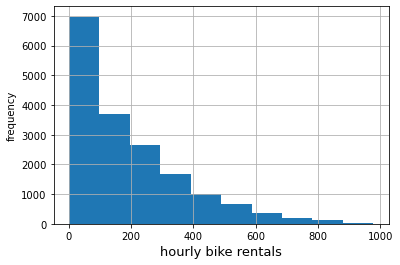

In [6]:
bike_rentals.cnt.hist()
plt.xlabel('hourly bike rentals', fontsize=13)
plt.ylabel('frequency')
plt.show()

We see that the bulk of the distribution is in the 0-200 range.

Finally, let's consider the correlation of the numeric variables with the target column.

In [7]:
bike_rentals[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr().cnt.sort_values(ascending=False)

cnt          1.000000
temp         0.404772
atemp        0.400929
windspeed    0.093234
hum         -0.322911
Name: cnt, dtype: float64

Temperature and humidity are quite connected to the bike rentals, the speed of wind much less.

We also expect temperature and adjusted temperature to be highly correlated:

In [8]:
round(bike_rentals.corr().atemp.temp, 3)

0.988

Yep. Now, it's generally advised to remove highly correlated features, but again I found that the models for some reason perform better by including it.<br/>
Actually, [this article](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/) makes some points about including redundant variables when the goal is prediction, which is our case. Because of this, `atemp` will not be dropped.

## Feature engineering

The dataset contains a hourly account of bike rentals. It can be convenient to group the hour of the day (from 0 to 23) in more coarse-grained groups (morning hours, afternoon hours etc.) so to give the algorithms a hint.

In [9]:
def assign_label(hour) -> int:
    """
    Take the hour of the day and classify it as morning, afternoon, evening or night.
    
    1: morning hours (6 to 11)
    2: afternoon hours (12 to 17)
    3: evening hours (18 to 23)
    4: night hours (0 to 5)
    """
    
    if hour in range(6, 12):
        return 1
    elif hour in range(12, 18):
        return 2
    elif hour in range(18, 24):
        return 3
    else:
        return 4
    
# apply the function to the "hr" column    
bike_rentals['time_label'] = bike_rentals.hr.apply(assign_label) 

Again, we should drop the `hr` column now that the time label has been created, but I found the models perform better when hours are included.

## Notes on the problem of categorical variables encoding

The dataset contains three numerical features and a few categorical variables (e.g. `weekday`, `weathersit`, `season`).

While numerical features are fine as they are, we must consider the encoding of categorical variables before the creation of the train and test datasets.<br/>
As far as linear regression is concerned, all the sources I consulted in the past agree on using one-hot encoding for nominal categorical variables; the situation is more nuanced for decision trees. In fact, in the [sklearn docs on DTs](https://scikit-learn.org/stable/modules/tree.html#tree), you read that **"scikit-learn implementation does not support categorical variables for now"**. This is a bit disappointing, especially considering that the problem is known and still not solved (check [this GitHub official discussion](https://github.com/scikit-learn/scikit-learn/issues/12398)).
It seems that different persons have different opinions about the issue, and one of the most solid references is [this article](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931) where the author tried different approaches. The result, at least for the dataset she uses, is that both one-hot encoding and numerical encoding (i.e. leaving the categorical features as they are at the moment) can give satisfying results. I have no better hint than trying both of them.

## Creating train and test datasets

Considering the problem mentioned in the previous paragraph, we will create two train/test pairs, one with numerical encoding, the other with one-hot encoding.<br/>
We'll use a 80/20 proportion.

In [10]:
# numerical encoding
train = bike_rentals.sample(frac=.8, random_state=rs).copy()
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)].copy()

# one-hot encoding
cols_one_hot_encode = ['weathersit', 'season', 'mnth', 'weekday', 'time_label', 'hr']
train_ohe = pd.get_dummies(train, columns=cols_one_hot_encode).copy()
test_ohe = pd.get_dummies(test, columns=cols_one_hot_encode).copy()

In [11]:
print(train.shape)
print(test.shape)
train.head()

(13903, 14)
(3476, 14)


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_label
15652,4,1,10,9,0,5,1,2,0.54,0.5152,0.94,0.1045,389,1
3085,2,0,5,11,0,5,1,2,0.52,0.5000,0.83,0.1642,146,1
1684,1,0,3,19,0,2,1,2,0.34,0.3182,0.71,0.2836,152,3
10555,1,1,3,22,0,2,1,1,0.54,0.5152,0.77,0.0000,188,3
14622,3,1,9,11,0,4,1,3,0.70,0.6667,0.84,0.1642,62,1


In [12]:
train_ohe.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,weathersit_2,...,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23
15652,1,0,1,0.54,0.5152,0.94,0.1045,389,0,1,...,0,0,0,0,0,0,0,0,0,0
3085,0,0,1,0.52,0.5000,0.83,0.1642,146,0,1,...,0,0,0,0,0,0,0,0,0,0
1684,0,0,1,0.34,0.3182,0.71,0.2836,152,0,1,...,0,0,0,0,0,1,0,0,0,0
10555,1,0,1,0.54,0.5152,0.77,0.0000,188,1,0,...,0,0,0,0,0,0,0,0,1,0
14622,1,0,1,0.70,0.6667,0.84,0.1642,62,0,0,...,0,0,0,0,0,0,0,0,0,0


## Linear regression models

In the next cell, we define a function so that we can try the linear model with different group of features.

In [13]:
def train_and_evaluate(train: pd.DataFrame, test: pd.DataFrame, features: list, target: str) -> None:
    '''
    Train a linear model on train set, evaluate its performance (RMSE) both on train and test set.
    Print the RMSE for both.
    '''
    
    # train model
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    
    # evaluate performance on train set
    predict_train = lr.predict(train[features])
    rmse_train = mean_squared_error(train[target], predict_train, squared=False)
    print(f'RMSE train: {round(rmse_train, 1)}')
    
    # evaluate performance on test set
    predict_test = lr.predict(test[features])
    rmse_train = mean_squared_error(test[target], predict_test, squared=False)
    print(f'RMSE test: {round(rmse_train, 1)}')
    
    return   

Let's try some combinations. The train/set pair will be the one-hot encoded.

- **numerical**

In [14]:
target = 'cnt'

In [15]:
num_cols = ['temp', 'hum', 'windspeed']

train_and_evaluate(train_ohe, test_ohe, num_cols, target)

RMSE train: 157.6
RMSE test: 154.4


- **numerical + season**

In [16]:
num_season = num_cols + [col for col in train_ohe.columns if 'season' in col]

train_and_evaluate(train_ohe, test_ohe, num_season, target)

RMSE train: 154.5
RMSE test: 151.1


- **numerical + season + weather conditions**

In [17]:
num_season_weath = num_season + [col for col in train_ohe.columns if 'weather' in col]

train_and_evaluate(train_ohe, test_ohe, num_season, target)

RMSE train: 154.5
RMSE test: 151.1


- **numerical + season + weather conditions + day of week**

In [18]:
num_season_weath_weekday = num_season_weath + [col for col in train_ohe.columns if 'weekday' in col]

train_and_evaluate(train_ohe, test_ohe, num_season_weath_weekday, target)

RMSE train: 154.3
RMSE test: 150.9


- **numerical + season + weather conditions + day of week + time label**

In [19]:
num_season_weath_weekday_time = num_season_weath_weekday + [col for col in train_ohe.columns if 'time_label' in col]

train_and_evaluate(train_ohe, test_ohe, num_season_weath_weekday_time, target)

RMSE train: 135.9
RMSE test: 132.4


- **all columns (numerical + categorical)**

In [20]:
features = [col for col in train_ohe.columns if col != 'cnt']

train_and_evaluate(train_ohe, test_ohe, features, target)

RMSE train: 101.4
RMSE test: 102.7


As we see, the best linear model is the one which uses **all the features** in the dataset. Also, a noticeable improvement in the performance is obtained when the time label is included (see last three linear models).<br/>
There's no evident overfitting, because the performances on train and test set are within a few percent one respect to the other.

With that being said, the linear models' performances are not brilliant: an average error of around 100 when most of the hours get less than 200 bike rentals.<br/>
Let's see if decision trees improve the predictions.

In [21]:
# record the best performance for final summary
rmses_linear = [101.4, 102.7] 

## Decision trees

In a similar fashion, we define a function which trains a decision tree on the given data.

In [22]:
def train_and_evaluate_tree(train, test, features: list, target: str,    
                            max_depth: int, min_samples: int,             
                            print_results=False, random_state=rs) -> tuple:
    """
    Train a decision tree on train set, evaluate its performance (RMSE) both on train and test set.
    Return RMSEs and print them if print_results=True.
    """
    
    # train model
    tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples, random_state=rs)
    tree.fit(train[features], train[target])
       
    # evaluate performance on train set
    predict_train = tree.predict(train[features])
    rmse_train = mean_squared_error(train[target], predict_train, squared=False)
            
    # evaluate performance on test set
    predict_test = tree.predict(test[features])
    rmse_test = mean_squared_error(test[target], predict_test, squared=False)
    
    if print_results:
        print(f'RMSE train: {round(rmse_train, 1)} || ', end='')
        print(f'RMSE test: {round(rmse_test, 1)}')
    
    return rmse_train, rmse_test 

### 1) Default sklearn parameters

Let's first try the default parameters, just to see if we are lucky.

In [23]:
feats_num_encode = [col for col in train.columns if col != 'cnt']
feats_ohe = [col for col in train_ohe.columns if col != 'cnt']

# use both the numerical encoding and the one-hot encoding to train and test
_ = train_and_evaluate_tree(train, test, feats_num_encode, 'cnt', None, 1, True)
_ = train_and_evaluate_tree(train_ohe, test_ohe, feats_ohe, 'cnt', None, 1, True)

RMSE train: 0.6 || RMSE test: 58.0
RMSE train: 0.6 || RMSE test: 66.6


As we expected, the decision trees with default parameters **severely overfit**. This is the main drawback of this kind of algorithm: if you leave it completely "free to choose", it will try to find the best rule for each example, at the cost of building a model that doesn't generalize at all, like in this case. The conclusion is the same for both kinds of encoding.

In order to prevent overfitting, we have three options:
- tweak the hyperparameters;
- prune the tree after it's been trained;
- use a random forest to average several trees predictions.

We now try all of them.

### 2) Tweaking the learning parameters

Let's consider two parameters: the maximum depth of the tree and the minimum number of samples a node must have to be a leaf. These parameters tend to interact with one another, so if we want to tweak the model manually, we need to consider both.

In [24]:
for d in range(3, 20):
    for min_samples in range(20, 41, 20):
        print(f'\033[1mdepth = {d}, min_samples = {min_samples}:\033[0m')
        print(f'\t\033[1mnumerical enc.:\033[0m\n\t', end='')
        _ = train_and_evaluate_tree(train, test, feats_num_encode, target='cnt', max_depth=d, min_samples=min_samples, print_results=True)
        print(f'\t\033[1mone-hot enc.:\033[0m\n\t', end='')
        _ = train_and_evaluate_tree(train_ohe, test_ohe, feats_ohe, target='cnt', max_depth=d, min_samples=min_samples, print_results=True)

depth = 3, min_samples = 20:
	numerical enc.:
	RMSE train: 129.6 || RMSE test: 127.1
	one-hot enc.:
	RMSE train: 133.6 || RMSE test: 130.8
depth = 3, min_samples = 40:
	numerical enc.:
	RMSE train: 129.6 || RMSE test: 127.1
	one-hot enc.:
	RMSE train: 133.6 || RMSE test: 130.8
depth = 4, min_samples = 20:
	numerical enc.:
	RMSE train: 119.2 || RMSE test: 117.7
	one-hot enc.:
	RMSE train: 122.6 || RMSE test: 121.7
depth = 4, min_samples = 40:
	numerical enc.:
	RMSE train: 119.2 || RMSE test: 117.7
	one-hot enc.:
	RMSE train: 122.6 || RMSE test: 121.7
depth = 5, min_samples = 20:
	numerical enc.:
	RMSE train: 107.5 || RMSE test: 107.8
	one-hot enc.:
	RMSE train: 110.7 || RMSE test: 109.4
depth = 5, min_samples = 40:
	numerical enc.:
	RMSE train: 107.5 || RMSE test: 107.8
	one-hot enc.:
	RMSE train: 110.7 || RMSE test: 109.4
depth = 6, min_samples = 20:
	numerical enc.:
	RMSE train: 100.4 || RMSE test: 100.9
	one-hot enc.:
	RMSE train: 103.9 || RMSE test: 104.3
depth = 6, min_samples = 40

The first thing we can notice is that the one-hot encoded dataset has always worse performances than the corresponding numerical encoded dataset. We will consider only the latter in the next models.<br/>
The overfitting has surely been reduced with respect to the default parameters, although it's still there especially for low values of min_samples.<br/>
The best tree among the ones we tried is the one with a **depth of 10** and **at least 40 samples per leaf**.

RMSE on train: 60.2<br/>
RMSE on test: 63.8

Out of curiosity, let's fix the depth parameter at 10 and let's make a plot of the RMSE as a function of the minimum number of samples.

In [25]:
# training and testing of the models with d=10

train_dt_tweak_rmses = []
test_dt_tweak_rmses = []
min_samples_values = list(range(1, 100, 2))

for min_samples in min_samples_values:
    rmse_train, rmse_test = train_and_evaluate_tree(train, test, feats_num_encode, 'cnt', 10, min_samples)
    train_dt_tweak_rmses.append(rmse_train)
    test_dt_tweak_rmses.append(rmse_test)

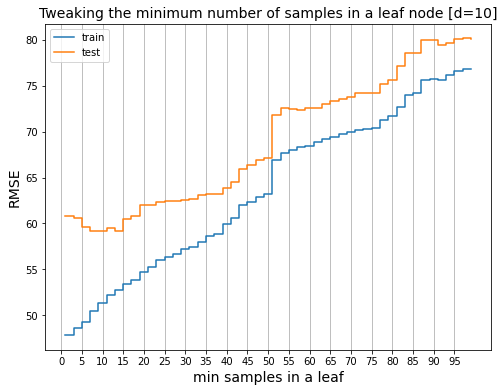

In [26]:
# plot the results
fig ,ax = plt.subplots(figsize=(8, 6))

ax.plot(min_samples_values, train_dt_tweak_rmses, label='train', drawstyle='steps-post')
ax.plot(min_samples_values, test_dt_tweak_rmses, label='test', drawstyle='steps-post')
ax.set_xticks(range(0, 100, 5))
ax.grid(axis='x')
ax.set_title('Tweaking the minimum number of samples in a leaf node [d=10]', fontsize=14)
ax.set_xlabel('min samples in a leaf', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.legend()

plt.show()

The plot shows that the tree clearly overfits for less than 5-10 samples in leaf nodes and for higher values the situation improves. It isn't so clear where the overfitting stops and we also have a sudden step at 51 samples which is hard to explain for my present knowledge.<br/>
We will call the best model the one we've already found.

In [27]:
rmses_tweaked_tree = [60.2, 63.8]

Let's see if pruning around those hyperparameters values brings some improvement.

### 3) Pruning

Pruning wasn't taught in the course about decision trees. At a high level, it consists in building the tree and then cutting the branches which bring relatively low reduction of entropy (or wathever metric is being used) by substituting them with leaves.<br/>
In sklearn, the procedure is defined by specifying a single parameter, **alpha**. In order to find the candidate values for alpha, we use the **cost_complexity_pruning_path** method of the DecisionTreeRegressor class.

In [28]:
# using the "optimal" parameters found in previous section
max_depth = 10
min_samples_leaf = 40

# determining alphas for cost complexity pruning
tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=rs)
pruning_path = tree.cost_complexity_pruning_path(train[feats_num_encode], train['cnt'])
alphas = pruning_path['ccp_alphas'][:-1]
alphas = [a for a in alphas if a >= 0]

print(len(alphas))

208


In [29]:
# the real job: using the alphas for pruning the tree and measuring performances after pruning

train_rmses = []
test_rmses = []

for i, alpha in enumerate(alphas):
    # printing every once in a while which alpha is being processed
    if i % 100 == 0:
        print(f'processing {i}-th alpha')
    tree = DecisionTreeRegressor(ccp_alpha=alpha, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=rs)
    tree.fit(train[feats_num_encode], train['cnt'])
    # train predictions and RMSE
    pred = tree.predict(train[feats_num_encode])
    train_rmses.append(mean_squared_error(train['cnt'], pred, squared=False))
    # test predictions and RMSE
    pred = tree.predict(test[feats_num_encode])
    test_rmses.append(mean_squared_error(test['cnt'], pred, squared=False))

processing 0-th alpha
processing 100-th alpha
processing 200-th alpha


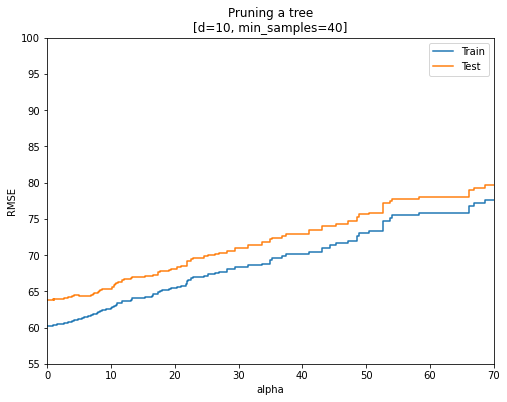

In [30]:
# plotting the results: rmse vs alpha

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(alphas, train_rmses, drawstyle='steps-post', label='Train')
ax.plot(alphas, test_rmses, drawstyle='steps-post', label='Test')
ax.legend()

# zoom on the optimal area of the plot
ax.set_xlim(0, 70)
ax.set_ylim(55, 100)

ax.set_title(f'Pruning a tree\n[d={max_depth}, min_samples={min_samples_leaf}]')
ax.set_ylabel('RMSE')
ax.set_xlabel('alpha')

plt.show()

From this zoom of the plot, we see that the best performances are for **alpha~0**, where the RMSEs are totally comparable to the ones we already found with the tweaking of section 2). Therefore, the best results remain the ones found there.<br/>
We could have expected this, since hyperparameters tuning and pruning are kind of alternative approaches to reduce overfitting.<br/>

### 4) Random forest

Random forests are a bunch of decision trees. They average the estimate of each tree in order to improve accuracy and prevent overfitting. The main feature of random forest is that each tree is trained on a sample of the dataset (bagging) and each node tries the split on a random subsample of dataset features.<br/>
Let's try some combinations of depth and minimun samples per leaf, building forests with 150 trees each.

In [31]:
for max_depth in range(8, 13, 2):
    for min_samples_leaf in range(10, 60, 10):
        
        rf = RandomForestRegressor(n_estimators=150, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=rs)
        rf.fit(train[feats_num_encode], train.cnt)
        print(f'depth={max_depth}, , min_samples={min_samples_leaf}\nRMSE train: ', end='')
        print(round(mean_squared_error(rf.predict(train[feats_num_encode]), train.cnt, squared=False), 1), end='')
        print(' || ', end='')
        print('RMSE test: ', end='')
        print(round(mean_squared_error(rf.predict(test[feats_num_encode]), test.cnt, squared=False), 1), end='')
        print()

depth=8, , min_samples=10
RMSE train: 63.2 || RMSE test: 67.5
depth=8, , min_samples=20
RMSE train: 64.3 || RMSE test: 68.0
depth=8, , min_samples=30
RMSE train: 65.8 || RMSE test: 69.4
depth=8, , min_samples=40
RMSE train: 67.8 || RMSE test: 70.9
depth=8, , min_samples=50
RMSE train: 69.1 || RMSE test: 72.2
depth=10, , min_samples=10
RMSE train: 47.8 || RMSE test: 54.2
depth=10, , min_samples=20
RMSE train: 52.7 || RMSE test: 57.4
depth=10, , min_samples=30
RMSE train: 58.0 || RMSE test: 61.9
depth=10, , min_samples=40
RMSE train: 63.0 || RMSE test: 66.4
depth=10, , min_samples=50
RMSE train: 65.9 || RMSE test: 69.4
depth=12, , min_samples=10
RMSE train: 43.2 || RMSE test: 50.9
depth=12, , min_samples=20
RMSE train: 50.6 || RMSE test: 55.8
depth=12, , min_samples=30
RMSE train: 57.0 || RMSE test: 61.1
depth=12, , min_samples=40
RMSE train: 62.5 || RMSE test: 66.0
depth=12, , min_samples=50
RMSE train: 65.6 || RMSE test: 69.2


The best performances are around the same values of depth (10) and minimum samples per leaf (~20). After a few tries, we found the best result at:

- depth = 10
- minimum samples per leaf: 15

In [32]:
rf = RandomForestRegressor(150, max_depth=10, min_samples_leaf=15, random_state=rs)
rf.fit(train[feats_num_encode], train.cnt)
print('RMSE train:', round(mean_squared_error(rf.predict(train[feats_num_encode]), train.cnt, squared=False), 1), '|| ', end='')
print('RMSE test:', round(mean_squared_error(rf.predict(test[feats_num_encode]), test.cnt, squared=False) , 1))
print()

RMSE train: 50.3 || RMSE test: 56.0



In [33]:
rmses_forest = [50.3, 56.0]

## **Conclusions**

Our predictions of bike rentals for the city of Washington D.C. clearly improved by using tree-based models with respect to a simple linear multivariate regression. One of the advantages of decision trees, in fact, is that they can easily catch non-linear relationship among variables.

Nonetheless, the performances of the best models were not completely satisfying: by using the random forest algorithm, we managed to decrease the RMSE by about 17% with respect to the single tree. This is significant, but still not enough to be usable in practice.<br/>
The table below will summarize the results quantitatively.

In [39]:
summary = pd.DataFrame({'Linear model': rmses_linear, 
              'Tweaked dec. tree [d=10, min_samples=40]': rmses_tweaked_tree,
              'Pruned dec. tree [same params.]': rmses_tweaked_tree,
              'Random forest [d=10, min_samples=15]': rmses_forest}).T

summary.rename({0: 'RMSE train', 1: 'RMSE test'}, axis=1, inplace=True)

summary

,RMSE train,RMSE test
Linear model,101.4,102.7
"Tweaked dec. tree [d=10, min_samples=40]",60.2,63.8
Pruned dec. tree [same params.],60.2,63.8
"Random forest [d=10, min_samples=15]",50.3,56.0


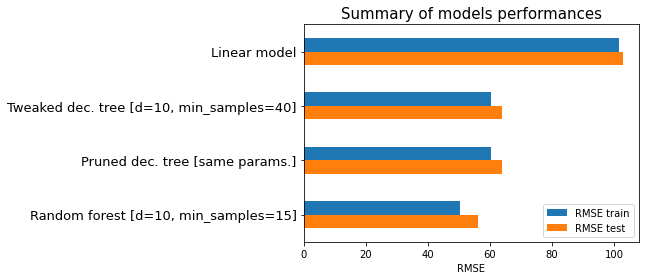

In [54]:
ax = summary.plot.barh()
ax.invert_yaxis()
ax.set_title('Summary of models performances', fontsize=15)
ax.set_xlabel('RMSE')
for item in ax.get_yticklabels():
    item.set_fontsize(13)

plt.show()